<a href="https://colab.research.google.com/github/LeeYuuuan/DDPMforEIT/blob/main/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import os
from torch.utils.data import TensorDataset,DataLoader,Dataset
import scipy.io
import numpy as np
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from collections import OrderedDict
from typing import Tuple, Union

In [ ]:
%%python --version

Python 3.10.12


In [ ]:
!nvidia-smi

Mon Feb  5 17:15:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing

In [ ]:
## TODO
class EITDataset(Dataset):
    """
    EIT simulation data

    when cond = 0.7:
        cond_file_name = "target_hpixel_data"
        vol_file_name = "target_voltage_data"


    """
    def __init__(self, cond_file_name, vol_file_name, transform=None, train_or_test=None):
        """
            args:
                cond_file_name: The name of the conductivity file.
                vol_file_name: The name of the voltage file.
                transform: function for transforming data (None for Not).
                train_or_test: generate training or test data (None for all).
        """

        self.transform = transform
        cond_dir = '/content/drive/MyDrive/Colab Notebooks/DDPM_EIT/EIT/' + cond_file_name + '.mat'
        raw_dir = '/content/drive/MyDrive/Colab Notebooks/DDPM_EIT/EIT/' + vol_file_name + '.mat'
        raw_cond = scipy.io.loadmat(cond_dir)
        raw_vol = scipy.io.loadmat(raw_dir)
        raw_cond[cond_file_name].shape
        self.conductivity = np.zeros([raw_cond[cond_file_name].shape[0], int(raw_cond[cond_file_name].shape[1]/2)])
        for j in range(raw_cond[cond_file_name].shape[0]):
            for i in range(1024):
                self.conductivity[j, i] = (raw_cond[cond_file_name][j, i * 2] + raw_cond[cond_file_name][j, i * 2 + 1]) / 2
        self.conductivity = self.conductivity.reshape([self.conductivity.shape[0], 32, 32])
        self.voltage = raw_vol[vol_file_name]

        if train_or_test is not None:
            X_train, X_test, y_train, y_test = train_test_split(self.conductivity, self.voltage, test_size=0.2, random_state=42)
            if train_or_test == "train":
                self.conductivity = X_train
                self.voltage = y_train
            elif train_or_test == "test":
                self.conductivity = X_test
                self.voltage = y_test
            else:
                raise ValueError


    def __len__(self):
        return len(self.conductivity)

    def __getitem__(self, index):
        return self.conductivity[index], self.voltage[index]




### test

6349


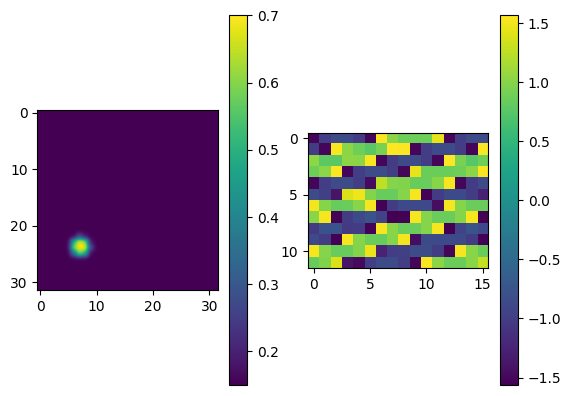

In [ ]:
def testEITDataset():
    test_eitdataset = EITDataset(cond_file_name = "target_hpixel_data", vol_file_name = "target_voltage_data")
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # plt.imshow(cond[0].reshape([32,32]), interpolation="antialiased")
    x, y = test_eitdataset.__getitem__(1000)
    print(test_eitdataset.__len__())
    g1 = ax1.imshow(x, interpolation="gaussian") # antialiased
    plt.colorbar(g1, ax=ax1)

    g2 = ax2.imshow(y.reshape([12, 16]))
    plt.colorbar(g2, ax=ax2)
    plt.show()

testEITDataset()


## Load

In [ ]:
def load_transformed_dataset(default_cond=None, default_radius=None, is_transform=True, if_split=False, dataset_type="train"):

    if default_cond is None and default_radius is None:
        cond_file_name = "target_hpixel_data"
        vol_file_name = "target_voltage_data"
    else:
        cond_file_name = "cond=" + str(default_cond) + "radius=" + str(default_radius) + "_target_hpixel_data"
        vol_file_name = "cond=" + str(default_cond) + "radius=" + str(default_radius) + "_target_voltage_data"

    data_transforms = [
        # transforms.Resize((IMG_SIZE, IMG_SIZE)),

        transforms.ToTensor(), # Scales data into [0,1] ???
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
    if is_transform is True and if_split is False:
        data_transform = transforms.Compose(data_transforms)
        data = EITDataset(cond_file_name=cond_file_name, vol_file_name=vol_file_name, transform=data_transform)
        return data

    if is_transform is True and if_split is True:
        data_transform = transforms.Compose(data_transforms)
        if dataset_type == "train" or dataset_type == "test":
            return EITDataset(cond_file_name=cond_file_name, vol_file_name=vol_file_name, transform=data_transform, train_or_test=dataset_type)
        else:
            raise ValueError
    if is_transform is not True and if_split is False:
        data = EITDataset(cond_file_name=cond_file_name, vol_file_name=vol_file_name)
        return data

    if is_transform is not True and if_split is True:
        if dataset_type == "train" or dataset_type == "test":
            return EITDataset(cond_file_name=cond_file_name, vol_file_name=vol_file_name, transform=data_transform, train_or_test=dataset_type)
        else:
            raise ValueError


In [ ]:


data = load_transformed_dataset(if_split=True)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
train_data = load_transformed_dataset(if_split=True)
test_data = load_transformed_dataset(if_split=True, dataset_type="test")
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

### for testing dataloader

In [ ]:
image = next(iter(dataloader))

### for showing image

In [ ]:
def show_image(cond, voltage=None):
    """This function is for showing image of conductivity and voltage."""
    if voltage is not None:
        fig, (ax1, ax2) = plt.subplots(1, 2)

        # plt.imshow(cond[0].reshape([32,32]), interpolation="antialiased")

        g1 = ax1.imshow(cond, interpolation="gaussian") # antialiased
        plt.colorbar(g1, ax=ax1)

        g2 = ax2.imshow(voltage.reshape([12, 16]))
        plt.colorbar(g2, ax=ax2)
        plt.show()
    else:
        plt.imshow(cond, interpolation="gaussian") # antialiased
        plt.colorbar()
        plt.show()



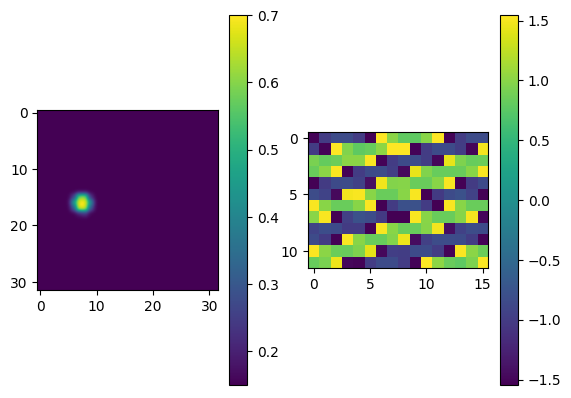

In [ ]:
show_image(image[0][0], image[1][0])

In [ ]:
image[1][0].shape

torch.Size([192])

## for test

In [ ]:
cond_file_name = "target_hpixel_data"
vol_file_name = "target_voltage_data"
cond_dir = '/content/drive/MyDrive/Colab Notebooks/DDPM_EIT/EIT/' + cond_file_name + '.mat'
raw_dir = '/content/drive/MyDrive/Colab Notebooks/DDPM_EIT/EIT/' + vol_file_name + '.mat'
raw_cond = scipy.io.loadmat(cond_dir)
raw_vol = scipy.io.loadmat(raw_dir)



In [ ]:
raw_cond[cond_file_name].shape
cond = np.zeros([raw_cond[cond_file_name].shape[0], int(raw_cond[cond_file_name].shape[1]/2)])

(6349, 192)

In [ ]:
for j in range(raw_cond[cond_file_name].shape[0]):
    for i in range(1024):
        cond[j, i] = (raw_cond[cond_file_name][j, i * 2] + raw_cond[cond_file_name][j, i * 2 + 1]) / 2

In [ ]:
cond = cond.reshape([cond.shape[0], 32, 32])

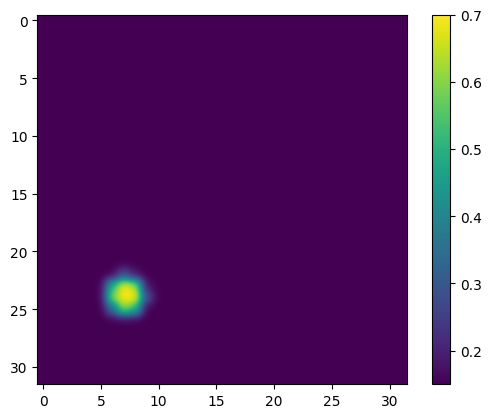

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# plt.imshow(cond[0].reshape([32,32]), interpolation="antialiased")
plt.imshow(cond[1000], interpolation="gaussian") # antialiased
plt.colorbar()
plt.show()

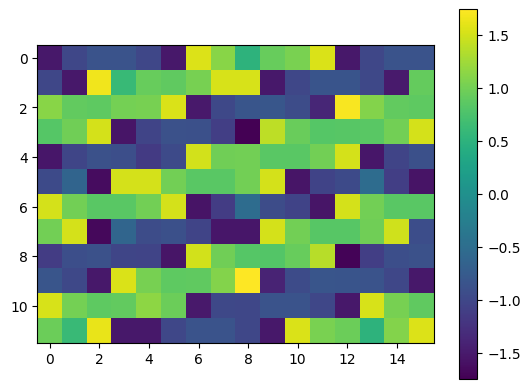

In [ ]:
plt.imshow(raw_vol[vol_file_name][0].reshape([12,16]))
plt.colorbar()
plt.show()

# Forward

In [ ]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

In [ ]:
timesteps = 200

# define beta schedule
betas = cosine_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0) #cumulative product
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [ ]:
# show beta
plt.plot([x for x in range(len(betas))], posterior_variance)

In [ ]:
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [ ]:
def get_noisy_image(x_start, t):
    # add noise
    x_noisy = q_sample(x_start, t=t)

    # turn back into PIL image
    show_image(x_noisy)

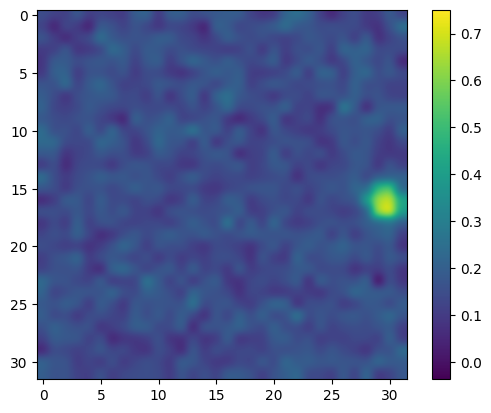

In [ ]:
t = torch.tensor([4])
get_noisy_image(image[0][0], t)

## Pre-train Block

https://github.com/moein-shariatnia/OpenAI-CLIP/blob/master/OpenAI%20CLIP%20Simple%20Implementation.ipynb

### test respectively

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu3 = nn.ReLU(inplace=True)

        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.relu2(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu3(out)
        return out

In [ ]:
mode_t = Bottleneck(1, 32)

In [ ]:
x = torch.randn(32, 1, 32, 32)

In [ ]:
mode_t(x).shape

torch.Size([32, 128, 32, 32])

In [ ]:
class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.flatten(start_dim=2).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = F.multi_head_attention_forward(
            query=x[:1], key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )
        return x.squeeze(0)



In [ ]:
spacial_dim = 32
embed_dim = 2048

nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5).shape

torch.Size([1025, 2048])

In [ ]:
spacial_dim = 32
embed_dim = 64
head = 8
output_dim = 8
att_t = AttentionPool2d(spacial_dim // 32, embed_dim * 32, head, output_dim)

att_t(torch.randn(100, 2048, 1, 1)).shape

torch.Size([100, 8])

In [ ]:
class ModifiedResNet(nn.Module):
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(self, layers, output_dim, heads, input_resolution=32, width=128):
        super().__init__()
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        # the 3-layer stem
        self.conv1 = nn.Conv2d(1, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.relu3 = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(2)

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # the ResNet feature dimension
        self.attnpool = AttentionPool2d(input_resolution // 32, embed_dim, heads, output_dim)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        def stem(x):
            x = self.relu1(self.bn1(self.conv1(x)))
            x = self.relu2(self.bn2(self.conv2(x)))
            x = self.relu3(self.bn3(self.conv3(x)))
            x = self.avgpool(x)
            return x

        x = x.type(self.conv1.weight.dtype)
        x = stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.attnpool(x)

        return x


In [ ]:
test_model = ModifiedResNet([3, 4, 6, 3], output_dim=1024, heads=64)
test_model(torch.randn(32, 1, 32, 32)).shape

torch.Size([32, 1024])

In [ ]:
class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)

class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.width = width
        self.layers = layers
        self.mlp = nn.Linear(192, width)
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        x = self.mlp(x)
        return self.resblocks(x)


In [ ]:
ra = Transformer(1024, 3, 8)

ra(torch.randn(32, 192)).type()

'torch.FloatTensor'

## build CLIP

In [ ]:
class CLIP(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int
                 ):

        """
        embed_dim is the dimention of the vectors for calculating similarity: default: 1024(512)
        transformer_width: the same as embed_dim: 1024(512)

        image_resolution: 32
        vision_layer: Default: Resnet-50 [3, 4, 6, 3]
        vision_width: Default: 128
        transformer_heads: 8
        transformer_layers: 3

        """

        super().__init__()
        # self.context_length = context_length

        vision_heads = vision_width * 32 // 64
        self.visual = ModifiedResNet(
            layers=vision_layers,
            output_dim=embed_dim,
            heads=vision_heads,
            input_resolution=image_resolution,
            width=vision_width)

        self.transformer = Transformer(
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
        )

        self.ln_final = LayerNorm(transformer_width)

        self.initialize_parameters()
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    def initialize_parameters(self):

        if self.visual.attnpool is not None:
            std = self.visual.attnpool.c_proj.in_features ** -0.5
            nn.init.normal_(self.visual.attnpool.q_proj.weight, std=std)
            nn.init.normal_(self.visual.attnpool.k_proj.weight, std=std)
            nn.init.normal_(self.visual.attnpool.v_proj.weight, std=std)
            nn.init.normal_(self.visual.attnpool.c_proj.weight, std=std)

        for resnet_block in [self.visual.layer1, self.visual.layer2, self.visual.layer3, self.visual.layer4]:
            for name, param in resnet_block.named_parameters():
                if name.endswith("bn3.weight"):
                    nn.init.zeros_(param)

        proj_std = (self.transformer.width ** -0.5) * ((2 * self.transformer.layers) ** -0.5)
        attn_std = self.transformer.width ** -0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)

    @property
    def dtype(self):
        return self.visual.conv1.weight.dtype

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    def encode_voltages(self, x):



        x = self.transformer(x).type(self.dtype)

        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        return x

    def forward(self, image, voltages):
        image_features = self.encode_image(image)
        voltages_features = self.encode_voltages(voltages)

         # normalized features
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        voltages_features = voltages_features / voltages_features.norm(dim=1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ voltages_features.t()
        logits_per_voltages = logits_per_image.t()

        # shape = [global_batch_size, global_batch_size]
        return logits_per_image, logits_per_voltages


In [ ]:
clip_m = CLIP(embed_dim=1024,
              image_resolution=32,
              vision_layers=[3, 4, 6, 3],
              vision_width=128,
              transformer_width=1024,
              transformer_heads=8,
              transformer_layers=3
              )

In [ ]:
simi_1, simi_2 = clip_m(image[0].unsqueeze(1).to(torch.float32), image[1].to(torch.float32))

In [ ]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()

In [ ]:
labels = torch.arange(32, device = device)
loss_i = cross_entropy_loss(simi_1, labels)
loss_t = cross_entropy_loss(simi_2, labels)
loss = (loss_i + loss_t)/2

### show similarity matrix

In [ ]:

# simi = simi_1.detach().numpy()[0:10, 0:10]
simi = simi_2.detach().numpy()[0:10, 0:10]
plt.imshow(simi, vmin=0.1, vmax=0.3)
for x in range(simi.shape[1]):
    for y in range(simi.shape[0]):
        plt.text(x, y, f"{simi[y, x]:.2f}", ha="center", va="center", size=12)

In [ ]:
def pre_train_loss_fn():


## Training

In [ ]:
train_iter_loss = []
test_iter_loss = []


In [ ]:
total = len(train_iter_loss)

In [ ]:
total = len(train_iter_loss)
epochs = 50
cross_entropy_loss = torch.nn.CrossEntropyLoss()
learning_rt = 0.0001
opt = torch.optim.Adam(clip_m.parameters(), lr=learning_rt)

clip_m.to(device)
for epoch in range(epochs):
    batch_train_loss = []
    batch_test_loss = []

    for i, (x, y) in enumerate(train_loader):
        batch_x = x.unsqueeze(1).to(torch.float32).to(device)
        batch_x.to(device)
        batch_y = y.to(torch.float32)
        batch_y = batch_y.to(device)


        logits_per_image, logits_per_voltages = clip_m(batch_x, batch_y) #forward

        labels = torch.arange(batch_x.shape[0], device = device)
        loss_i = cross_entropy_loss(logits_per_image, labels)
        loss_t = cross_entropy_loss(logits_per_voltages, labels)
        loss = (loss_i + loss_t)/2

        batch_train_loss.append(loss.cpu().detach().numpy())
        opt.zero_grad()
        loss.backward()
        opt.step()


        # print('train Loss {}:\t'.format(i), loss.item())
            # torch.save(model, '/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/model')

    train_iter_loss.append(np.average(np.array(batch_train_loss)))
    batch_train_loss = []




    for a,b in test_loader:

        test_x = a.unsqueeze(1).to(torch.float32)
        test_x = test_x.to(device)
        test_y = b.to(torch.float32)
        test_y = test_y.to(device)

        logits_per_image, logits_per_voltages = clip_m(batch_x, batch_y)


        labels = torch.arange(batch_x.shape[0], device = device)
        loss_i = cross_entropy_loss(logits_per_image, labels)
        loss_t = cross_entropy_loss(logits_per_voltages, labels)
        loss = (loss_i + loss_t)/2

        batch_test_loss.append(loss.cpu().detach().numpy())

        # print('test MSE {}:\t'.format(epoch+1), loss.item())
    test_iter_loss.append(np.average(np.array(batch_test_loss)))
    batch_test_loss = []
    print(f"epoch:{epoch},train loss:{train_iter_loss[epoch + total]}, test loss:{test_iter_loss[epoch + total]}")






epoch:0,train loss:0.07652071118354797, test loss:0.04291674867272377
epoch:1,train loss:0.0847695991396904, test loss:0.018314141780138016
epoch:2,train loss:0.0801851749420166, test loss:0.08007511496543884
epoch:3,train loss:0.07964412122964859, test loss:0.08538394421339035
epoch:4,train loss:0.07048732042312622, test loss:0.05097343400120735
epoch:5,train loss:0.06503628194332123, test loss:0.0016189204761758447
epoch:6,train loss:0.07209916412830353, test loss:0.06424792855978012
epoch:7,train loss:0.08837790787220001, test loss:0.05295869708061218
epoch:8,train loss:0.08421049267053604, test loss:0.05107400193810463
epoch:9,train loss:0.071806401014328, test loss:0.05082663148641586
epoch:10,train loss:0.06964220851659775, test loss:0.036089204251766205
epoch:11,train loss:0.07365534454584122, test loss:0.062357205897569656
epoch:12,train loss:0.05678781494498253, test loss:0.05635765194892883
epoch:13,train loss:0.06005284935235977, test loss:0.06121423840522766
epoch:14,train 

In [ ]:
torch.save(clip_m, '/content/drive/MyDrive/Colab Notebooks/DDPM_EIT/EIT/model')

train_loss_save = np.array(train_iter_loss)
test_loss_save = np.array(test_iter_loss)
np.save('/content/drive/MyDrive/Colab Notebooks/DDPM_EIT/EIT/training_loss.npy', train_loss_save)
np.save('/content/drive/MyDrive/Colab Notebooks/DDPM_EIT/EIT/test_loss.npy',test_loss_save)

In [ ]:
def clip_train():
    raise NotImplementedError


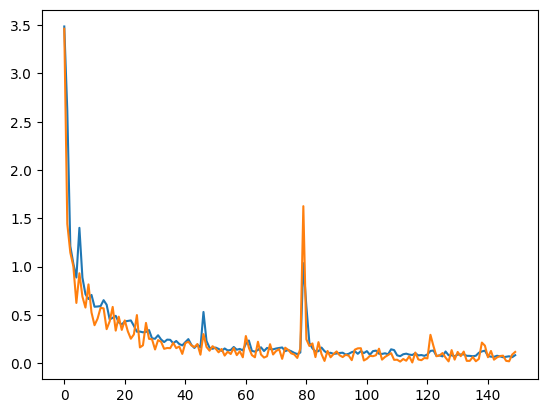

In [ ]:
plt.plot([c for c in range(total + epoch)], train_iter_loss)
plt.plot([c for c in range(total + epoch)], test_iter_loss)


### all

In [ ]:
test_model = ModifiedResNet([3, 4, 6, 3], output_dim=1024, heads=8)
test_model(torch.randn(32, 1, 32, 32))

tensor([[-0.6109, -0.4749, -0.5306,  ..., -0.3450,  0.3002,  1.2190],
        [-0.6214, -0.3956, -0.2325,  ..., -0.4584, -0.4125,  0.0266],
        [ 0.0324, -0.4909, -0.3335,  ..., -0.3309, -0.5048,  0.5535],
        ...,
        [-0.0463, -1.3396, -0.3544,  ..., -0.1106, -0.1085,  0.6233],
        [-0.2577, -0.1285,  0.5769,  ..., -0.5697, -0.2555,  0.5122],
        [ 0.1313, -0.7219, -0.3546,  ..., -0.8884, -0.1920,  0.2558]],
       grad_fn=<SqueezeBackward1>)

In [ ]:
model.eval()
resfile = open('res.csv', 'w')
for i in range(0, 2000):
    #加载当前的图片
    img_path = 'F:/学习资源/deep-learning-for-image-processing-master/data_set/cat_dog/test/' + str(i) + '.jpg'
        img = Image.open(img_path)
        img = data_transform(img)
        img = torch.unsqueeze(img, dim=0)
        with torch.no_grad():
            # predict class
            output = torch.squeeze(model(img.to(device))).cpu()
            predict = torch.softmax(output, dim=0)
            predict_cla = torch.argmax(predict).numpy()
            print(img_path,":",predict_cla.item())
            resfile.write(str(i) + ',' + str(predict_cla.item()))
    resfile.close()



## diffusion block

https://github.com/kjsman/stable-diffusion-pytorch/blob/main/stable_diffusion_pytorch/encoder.py

### test cross attention block

In [ ]:
import torch
from torch import nn
x = torch.randn(135, 1, 1024)
y = torch.randn(135, 1, 256)
input_shape = x.shape
batch_size, sequence_length, d_embed = input_shape


In [ ]:


interim_shape = (batch_size, -1, n_heads, d_head)

In [ ]:
d_embed = 1024
n_heads = 8
d_cross = 256
d_head = d_embed // n_heads
in_proj_bias = True
q_proj = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
k_proj = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
v_proj = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
out_proj = nn.Linear(d_embed, d_embed, bias=in_proj_bias)

In [ ]:
interim_shape

(135, -1, 8, 128)

In [ ]:
q = q_proj(x)
k = k_proj(y)
v = v_proj(y)

torch.Size([135, 1, 1024])

In [ ]:
q.view(interim_shape).shape

torch.Size([135, 1, 8, 128])

In [ ]:
q.view(interim_shape).transpose(1, 2).shape

torch.Size([135, 8, 1, 128])

In [ ]:
q = q.view(interim_shape).transpose(1, 2)
k = k.view(interim_shape).transpose(1, 2)
v = v.view(interim_shape).transpose(1, 2)

In [ ]:
import math
import torch.nn.functional as F
weight = q @ k.transpose(-1, -2)
weight /= math.sqrt(d_head)
weight = F.softmax(weight, dim=-1)
output = weight @ v
output = output.transpose(1, 2).contiguous()
output = output.view(input_shape)
output = out_proj(output)

In [ ]:
output.shape

torch.Size([135, 1, 1024])